<a href="https://colab.research.google.com/github/ssaabbii/math_statistics/blob/main/lab11.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw

cuda:0
Epoch: 0/10, Test acc: 73.30, Train acc: 75.32
Epoch: 1/10, Test acc: 79.13, Train acc: 81.72
Epoch: 2/10, Test acc: 81.50, Train acc: 84.75
Epoch: 3/10, Test acc: 83.90, Train acc: 87.22
Epoch: 4/10, Test acc: 84.30, Train acc: 88.41
Epoch: 5/10, Test acc: 84.05, Train acc: 88.17
Epoch: 6/10, Test acc: 84.32, Train acc: 87.79
Epoch: 7/10, Test acc: 85.79, Train acc: 89.66
Epoch: 8/10, Test acc: 86.19, Train acc: 90.03
Epoch: 9/10, Test acc: 86.20, Train acc: 90.45


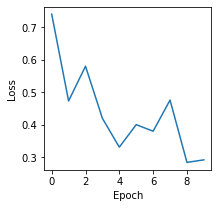

Test acc: 86.20, Train acc: 90.45


In [1]:
import torch.nn as nn
import math
import matplotlib.pyplot as plt
import numpy as np
import torchvision
import torchvision.transforms as transforms
import torch
from torch import optim
plt.figure(figsize = (3,3))

class Bottleneck(nn.Module):

    def __init__(self, inplanes, planes, stride=1, downsample=None, expansion=1):
        super(Bottleneck, self).__init__()
        self.conv1 = nn.Conv2d(inplanes, inplanes*expansion, kernel_size=1, bias=False)
        self.bn1 = nn.BatchNorm2d(inplanes*expansion)
        self.conv2 = nn.Conv2d(inplanes*expansion, inplanes*expansion, kernel_size=3, stride=stride,
                               padding=1, bias=False, groups=inplanes*expansion)
        self.bn2 = nn.BatchNorm2d(inplanes*expansion)
        self.conv3 = nn.Conv2d(inplanes*expansion, planes, kernel_size=1, bias=False)
        self.bn3 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x

        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        out = self.relu(out)

        out = self.conv3(out)
        out = self.bn3(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out


class MobileNetV2(nn.Module):

    def __init__(self, block, layers, num_classes=1000):
        self.inplanes = 32
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, stride=2, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu = nn.ReLU(inplace=True)
        self.layer1 = self._make_layer(block, 16, layers[0], stride=1, expansion = 1)
        self.layer2 = self._make_layer(block, 24, layers[1], stride=2, expansion = 6)
        self.layer3 = self._make_layer(block, 32, layers[2], stride=2, expansion = 6)
        self.layer4 = self._make_layer(block, 64, layers[3], stride=2, expansion = 6)
        self.layer5 = self._make_layer(block, 96, layers[4], stride=1, expansion = 6)
        self.layer6 = self._make_layer(block, 160, layers[5], stride=2, expansion = 6)
        self.layer7 = self._make_layer(block, 320, layers[6], stride=1, expansion = 6)
        self.conv8 = nn.Conv2d(320, 1280, kernel_size=1, stride=1, bias=False)
        self.avgpool = nn.AvgPool2d(1, stride=1)
        self.conv9 = nn.Conv2d(1280,num_classes, kernel_size=1, stride=1, bias=False)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride, expansion):

        downsample = nn.Sequential(
            nn.Conv2d(self.inplanes, planes,
                      kernel_size=1, stride=stride, bias=False),
            nn.BatchNorm2d(planes),
        )

        layers = []
        layers.append(block(self.inplanes, planes, stride=stride, downsample=downsample, expansion=expansion))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes, expansion=expansion))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)
        x = self.layer5(x)
        x = self.layer6(x)
        x = self.layer7(x)

        x = self.conv8(x)
        x = self.avgpool(x)
        x = self.conv9(x)
        x = x.view(x.size(0),-1)

        return x



def mobilenetv2():
    """Constructs a MobileNetV2-19 model.
    """
    model = MobileNetV2(Bottleneck, [1, 2, 3, 4, 3, 3, 1])
    return model



#increase the batch size
batch_size = 128

#download the data again and set the train, test loader with different batch size
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size, shuffle=True)
testset = torchvision.datasets.FashionMNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False)
#sneak peak into the train data

#iterating into the data
dataiter = iter(trainloader)
images, labels = dataiter.next()

#print(images.shape) #shape of all 4 images
#print(images[1].shape) #shape of one image
#print(labels[1].item()) #label number

classes = ('T-Shirt','Trouser','Pullover','Dress','Coat','Sandal','Shirt','Sneaker','Bag','Ankle Boot')


 

net = mobilenetv2()

#reference a variable to gpu card
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#function to do evaluation (calculate the accuracy) in gpu
def evaluation(dataloader):
    total, correct = 0, 0
    
    #keeping the network in evaluation mode
    net.eval()
    for data in dataloader:
        inputs, labels = data
        #moving the inputs and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = net(inputs)
        _, pred = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

#create the model object and move it to GPU
net = mobilenetv2().to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(net.parameters())



loss_arr = []
loss_epoch_arr = []
max_epochs = 10

for epoch in range(max_epochs):
    #iterate through all the batches in each epoch
    for i, data in enumerate(trainloader, 0):
        
        #keeping the network in training mode
        net.train()
    
        inputs, labels = data
        #moving the input and labels to gpu
        inputs, labels = inputs.to(device), labels.to(device)
        #clear the gradients
        opt.zero_grad()
        #forward pass
        outputs = net(inputs)
        loss = loss_fn(outputs, labels)
        #backward pass
        loss.backward()
        opt.step()
        
        loss_arr.append(loss.item())
        
    loss_epoch_arr.append(loss.item())
        
    print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (epoch, max_epochs, evaluation(testloader), evaluation(trainloader)))
    
    
plt.plot(loss_epoch_arr)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()

print('Test acc: %0.2f, Train acc: %0.2f' % (evaluation(testloader), evaluation(trainloader)))

# Новый раздел